In [3]:
# SPFDM Assignment 2
# Luuk Oudshoorn and Willem-Jan de Voogd
# Fall 2020

In [2]:
import time
import numpy as np
import pandas as pd
import datetime as dt
from glob import glob
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
from scipy import interpolate
from scipy.stats import norm
from joblib import Parallel, delayed
import networkx as nx
from scipy.stats import norm
import scipy as sp
import matplotlib.pyplot as plt
import ffn 
from matplotlib import collections as matcoll
%matplotlib inline

C:\Users\Willem Jan\anaconda3\lib\site-packages\ffn\core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


Exercise 10 (Stochastic  volatility).
Simulate the paths to maturity T= 1 year. Use the SABR model.
1.  Plot a single path and look if you can observe a volatility clustering.
2.  Plot  histograms  of  log-returns  and  compare  them  to  the  normal  
distribution with the same mean and variance.  Observe the skewness and fattails.

In [91]:
class StochVol():
    def __init__(self,Npaths, Nsteps, T, F, sigma, alpha, beta, rho, K = 3300, rf=None):
        """Function initialization like in the binomial tree model. 
           Predominantly fixed values"""
        """F is the initial forward rate, sigma the initial stochastic volatility."""
        # If we do not call the function with a value, 
        # initialize at the "standard" numbers
        if rf == 0:
            self.rf = rf
        elif not rf:
            self.rf = np.log((1+0.005/4)**4)
        else:
            self.rf = rf
        self.S0 = F*np.exp(-self.rf*T)
        self.F0 = F
        self.sigma0 = sigma
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.K     = K
        self.Npaths = Npaths
        self.Nsteps = Nsteps
        self.T = T
        self.dT = T/Nsteps
        
    def propagate(self,ft_1,st_1):
        """Equate the monte carlo iteration as function of location xt"""
        """ft and st are, respectively, the forward rate and the stochastic volatility at time t"""
        
        N = 1 if type(ft_1)==np.float64 else len(ft_1)
        # Generate Correlated Brownian motions
        x = np.random.randn(N)*np.sqrt(self.dT)
        e = np.sqrt(1-(self.rho)**2) * np.random.randn(N)*np.sqrt(self.dT)
        y = self.rho*x+e
       
        # Simulate standard deviations and forward rates
        st = st_1 + self.alpha*st_1*x
        ft = ft_1 + st_1*(ft_1**self.beta)*y
        return ft, st

    def simulate(self):
        """Iterate through the MC process for N steps and 1 path"""
        """ft and st are, respectively, the forward rate and the stochastic volatility at time t"""
        ft = np.zeros(self.Nsteps)
        st = np.zeros(self.Nsteps)
        prices = np.zeros(self.Nsteps)
        # Initialize at start value
        ft[0] = self.F0
        st[0] = self.sigma0
        prices[0] = self.S0
        
        for i in range(self.Nsteps-1):
            # propagate prices
            ft[i+1], st[i+1] = self.propagate(ft[i], st[i])
            prices[i+1] = ft[i+1]*np.exp(-self.rf*(self.T - (i+1)*self.dT))
        return prices, st
        
    def plot_single(self, filename=None):
        """Plot a single realization"""
        prices, volatilities = self.simulate()
        timearr = np.arange(0,self.T,self.dT)
        plt.plot(timearr,prices,color='black',lw=0.5)
        # plot horitontal line at long term mean
#         plt.axhline(self.ltm,ls='--',color='black',lw=1)
        plt.xlabel('Time [yr]')
        plt.ylabel('Stock price [USD]')
        plt.tight_layout()
        if filename:
            plt.savefig(filename)
        plt.show()
        plt.plot(volatilities)
        plt.show()
        
    def simulate_many(self):
        """Simulate Npaths for Nsteps"""
        """ft and st are, respectively, the forward rate and the stochastic volatility at time t"""
        ft = np.zeros((self.Npaths, self.Nsteps))
        st = np.zeros((self.Npaths, self.Nsteps))
        prices = np.zeros((self.Npaths, self.Nsteps))
        # Same as before but now a whole matrix with N paths
        ft[:,0] = self.F0
        st[:,0] = self.sigma0
        prices[:,0] = self.S0
        for i in range(self.Nsteps-1):
            ft[:,i+1], st[:,i+1] = self.propagate(ft[:,i], st[:,i])
            prices[:,i+1] = ft[:,i+1]*np.exp(-self.rf*(self.T - (i+1)*self.dT))
        return prices, st
        
    def plot_many(self, logreturns=False):
        """Make a plot of the overall distribution and also plot the resulting PDF of final 
           prices."""
        prices,vola = self.simulate_many()
        if logreturns==True:
            P = np.diff(np.log(prices))
            timearr = np.arange(self.dT,self.T,self.dT)
        else: 
            P = prices
            timearr = np.arange(0,self.T,self.dT)
        fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]},figsize=(8,1.7))
        for i in range(self.Npaths-1):
            a0.plot(timearr,P[i,:],color='black',lw=0.002)
        a0.plot(timearr,P[i,:],color='green',lw=1.0)
        a0.set_xlabel('Time [yr]')
        a0.set_ylabel('Stock price [USD]')
        
        bins = np.linspace(np.quantile(P[:,-1],0.01),np.quantile(P[:,-1],0.99), 100)
        a1.hist(P[:,-1],bins=bins, color='gray', density=True,orientation='horizontal')
        mean,std=norm.fit(P[:,-1])
        #x = np.linspace(-0.015, 0.015, 100)
        #y = norm.pdf(x, mean, std)
        #a1.plot(x, y)
        a1.set_xticks([])
        a1.set_yticks([])
        a0.set_rasterized(True)
        fig.tight_layout(pad=-0.3)
        a0.set_ylim(np.quantile(P[:,-1],0.01),np.quantile(P[:,-1],0.99))
        a1.set_ylim(np.quantile(P[:,-1],0.01),np.quantile(P[:,-1],0.99))
        plt.savefig('manyMCtracks_PDF.png', dpi=400,bbox_inches='tight')
        plt.show()

        
    def black_scholes(self,S, K, T, r, sigma, call_put='call'):   
        """Return black scholes price of an option"""
        #S: spot price
        #K: strike price
        #T: time to maturity
        #r: interest rate
        #sigma: volatility of underlying asset
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

        if call_put == 'call':
            optionprice = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
        elif call_put == 'put':
            optionprice = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        return optionprice

    
    def minimizer(self,params,type_):
        SABR_price, strike = params
        optim = minimize(fun=(lambda implied_vola: np.abs(self.black_scholes(self.F0, 
                                                     strike, 
                                                     self.T,
                                                     self.rf,
                                                     implied_vola,
                                                     call_put=type_)-SABR_price)),x0=0.4,tol=1e-10,method='Nelder-Mead')
        return optim.x

    def parallel_option(self,K,type_='call'):
        return self.option_price(optiontype=type_,K=K)
    
    def calc_implied_vola(self, ret=False,plot=False):
        """For different strikes, we calculate the SABR option price and the implied volatility
           which is the volatility to match the BS price to the SABR option price"""
        # Define range of strike ratios
        ratiorange = np.linspace(0.6,1.4,20)
        # Convert ratio to true strike price
        strikerange = ratiorange * self.F0
        # for each of these strikes, obtain SABR option price
        prices = np.array(Parallel(n_jobs=20)(delayed(self.parallel_option)(K,'call') for K in strikerange))
        # obtain implied vola for every price
        
        implied_volas = np.zeros(len(prices))
        BSprices      = np.zeros(len(prices))
        
        
        implied_volas = np.array(Parallel(n_jobs=20)(delayed(self.minimizer)(params,type_='call') for params in zip(prices,strikerange)))
        BSprices = np.array([self.black_scholes(self.F0,strikerange[w], 
                                                 self.T,
                                                 self.rf,
                                                 implied_volas[w],
                                                 call_put='call') for w in range(len(prices))])
        #for i in zip(prices,strikerange):
        #    print(i)
        if plot:
            plt.plot(ratiorange, implied_volas*100)
            plt.xlabel(r'$\frac{K}{S_0}$')
            plt.ylabel('Implied volatility (%)')
            plt.tight_layout()
            plt.savefig('Impliedvola_BS.pdf')
            plt.show()

            plt.plot(ratiorange, prices, label='SABR')
            plt.plot(ratiorange, np.max(np.vstack((np.zeros(len(strikerange)),self.F0-strikerange)),axis=0))
            plt.plot(ratiorange, BSprices,label='BS')
            plt.legend()
            plt.show()
        if ret:
            return ratiorange, implied_volas*100
        
        
    def plot_prices_strikes(self):
        """This function will create K/S0 plot of call and put prices for SABR and BS model"""
        # Define range of strike ratios
        ratiorange = np.arange(0.75,1.25,0.01)
        # Convert ratio to true strike price
        strikerange = ratiorange * self.F0
        # for each of these strikes, obtain SABR option price
        SABRcall = np.array(Parallel(n_jobs=22)(delayed(self.parallel_option)(K,'call') for K in strikerange))
        SABRput  = np.array(Parallel(n_jobs=22)(delayed(self.parallel_option)(K,'put') for K in strikerange))
    
        # Set BS vola to initial SABR vola
        # Find volatility that sets BS price at K=S to SABR price
        BSvolacall = self.minimizer((SABRcall[np.argmin(np.abs(ratiorange-1))],self.F0),'call')
        BSvolaput  = self.minimizer((SABRput[np.argmin(np.abs(ratiorange-1))],self.F0),'put')
        
        
        # Obtain BS prices for calls and puts 
        BScall   = np.array([self.black_scholes(self.F0,strike, 
                                                 self.T,
                                                 self.rf,
                                                 BSvolacall,
                                                 call_put='call') for strike in strikerange])
        BSput   = np.array([self.black_scholes(self.F0,strike, 
                                                 self.T,
                                                 self.rf,
                                                 BSvolaput,
                                                 call_put='put') for strike in strikerange])
        
        # Start plotting
        fig, ax = plt.subplots()
        ax.plot(strikerange,SABRcall, label='SABR Call')
        ax.plot(strikerange,SABRput,  label='SABR Put')
        ax.plot(strikerange,BScall,   label='BS Call')
        ax.plot(strikerange,BSput,    label='BS Put')
        ax.set_xlabel(r'$\frac{K}{S_0}$')
        ax.set_ylabel('Option price')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def option_price(self, optiontype='call',K=None):
        """Equate option price by taking option value for each path, averaging and discounting back 
           to present day value using risk free rate. """
        # Get prices 
        if not K:
            K = self.K
        prices, volatility = self.simulate_many()
        # Get final prices
        finalprices = prices[:,-1]
        # calculate option values
        if optiontype == 'call':
            optionvalues = np.max(np.vstack((np.zeros(len(finalprices)),finalprices-K)),axis=0)
        elif optiontype == 'put':
            optionvalues = np.max(np.vstack((np.zeros(len(finalprices)),K-finalprices)),axis=0)
        optionvalue = np.mean(optionvalues)
        # Discount to present value
        optionvalue = np.exp(-self.rf*self.T) * optionvalue
        return optionvalue
    
    def analytic_impliedvol(self, K):
        """Returns the analytic solution for implied volatility using BS"""
        # geometric average as midpoint
        F_mid = np.sqrt(self.F0*K)
        # calculate all other parameters needed
        xi = (self.alpha/(self.sigma0*100*(1-self.beta)))*(self.F0**(1-self.beta)-K**(1-self.beta))
        D_xi = np.log(np.sqrt(1-2*self.rho*xi + xi**2) + xi - self.rho)
        gamma_1 = self.beta/F_mid
        gamma_2 = -((self.beta*(1-self.beta))/F_mid**2)
        epsilon = self.T*self.alpha**2
        firstpart = self.alpha*((np.log(self.F0/K))/D_xi)
        secondpart = ((2*gamma_2-gamma_1**2+1/F_mid**2)/24)*((self.sigma0*100*F_mid**self.beta)/self.alpha)**2 + (self.rho*gamma_1/4)*((self.sigma0*100*F_mid**self.beta)/self.alpha) + (2-3*self.rho**2)/24
        return firstpart*(1+secondpart*epsilon)
    
    def analytic_impliedvol_paper(self,K):
# #         nu = self.sigma0*100
#         nu = self.alpha
#         tau = self.T
#         epsilon = self.T*self.alpha**2
#         T1 = epsilon*self.alpha / ((self.F0*K)**((1-self.beta)/2))
#         T2 = (1+(1-self.beta)**2/24 * (np.log(self.F0/K))**2 + (1-self.beta)**4/1920 * (np.log(self.F0/K))**4)**(-1)
#         zeta = nu / self.alpha * (self.F0*K)**((1-self.beta)/2) * np.log(self.F0/K)
#         xi_hat = np.log((np.sqrt(1-2*self.rho * zeta + zeta**2) - self.rho + zeta)/(1-self.rho))
#         T3 = (zeta / xi_hat)
#         T4 = (1+((1-self.beta)**2 * self.alpha**2 / (24*(self.F0*K)**(1-self.beta))) + (self.rho*self.alpha*nu*self.beta)/(4*(self.F0*K)**(1-self.beta)) + (2-3*self.rho**2)/24 * nu**2) * epsilon**2 * tau
        #         nu = self.sigma0*100
#         nu = self.alpha
        tau = self.T
        epsilon = self.T*self.sigma0**2
        T1 = epsilon*self.sigma0 / ((self.F0*K)**((1-self.beta)/2))
        T2 = (1+(1-self.beta)**2/24 * (np.log(self.F0/K))**2 + (1-self.beta)**4/1920 * (np.log(self.F0/K))**4)**(-1)
        zeta = self.alpha / self.sigma0 * (self.F0*K)**((1-self.beta)/2) * np.log(self.F0/K)
        xi_hat = np.log((np.sqrt(1-2*self.rho * zeta + zeta**2) - self.rho + zeta)/(1-self.rho))
        T3 = (zeta / xi_hat)
        T4 = (1+((1-self.beta)**2 * self.sigma0**2 / (24*(self.F0*K)**(1-self.beta))) + (self.rho*self.sigma0*self.alpha*self.beta)/(4*(self.F0*K)**(1-self.beta)) + (2-3*self.rho**2)/24 * self.alpha**2) * epsilon**2 * tau
        return T1*T2*T3*T4
        
    def plot_analytic_impliedvol(self,plot=True,ret=False):
        # Plot implied vol calculated with analytic solution
        # Define range of strike ratios
        ratiorange = np.arange(0.5,2.5,0.03)
        # Convert ratio to true strike price
        strikerange = ratiorange * self.F0

        # obtain implied vola for every price
        implied_volas = np.zeros(len(strikerange))
        for i, K in enumerate(strikerange):
            implied_volas[i] = self.analytic_impliedvol_paper(K)
#         print(np.max(implied_volas))
        if plot:    
            plt.plot(ratiorange, implied_volas*100)
            plt.xlabel(r'$\frac{K}{S_0}$')
            plt.ylabel('Implied volatility (%)')
            plt.tight_layout()
            plt.savefig('Impliedvola_BS.pdf')
            plt.show()
        if ret:
            return ratiorange, implied_volas*100
SV = StochVol(100000,10,T=1.5,F=3500, sigma=0.2, alpha=0.5, beta=1, rho=-0.7,K=3500, rf=0)

In [61]:
SV = StochVol(2500000,50,T=1.5,F=3500, sigma=0.1953, alpha=0.5, beta=1, rho=-0.7,K=3500, rf=0)
ratios1,volas1 = SV.calc_implied_vola(ret=True,plot=False)
ratios2,volas2 = SV.plot_analytic_impliedvol(plot=False,ret=True)

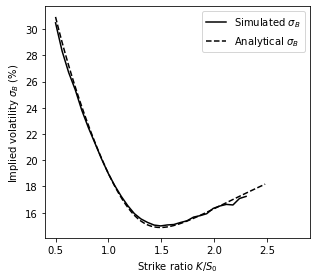

In [62]:
plt.figure(figsize=(4.5,4))
plt.plot(ratios1,volas1,color='black',label='Simulated $\sigma_B$')
plt.plot(ratios2,3500*volas2,color='black', ls='--', label='Analytical $\sigma_B$')
plt.ylabel(r'Implied volatility $\sigma_B$ (%)')
plt.xlabel(r'Strike ratio $K/S_0$')
plt.xlim(0.4,2.9)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('ImpliedVola_sim_ana.pdf')

In [122]:
import matplotlib.patches as patches
class parameters_panel():
    def __init__(self):
        return
    
    def vary_rho(self):
        rho1 = -0.7
        SV1 = StochVol(30000,15,T=1.5,F=3500, sigma=0.2, alpha=0.5, beta=1, rho=rho1,K=3500, rf=0)
        ratios1,volas1 = SV1.calc_implied_vola(ret=True,plot=False)
        
        rho2 = 0.3
        SV2 = StochVol(30000,15,T=1.5,F=3500, sigma=0.2, alpha=0.5, beta=1, rho=rho2,K=3500, rf=0)
        ratios2,volas2 = SV2.calc_implied_vola(ret=True,plot=False)
        plt.figure(figsize=(4.5,4))
        plt.plot(ratios1,volas1,color='black',label=r'$\rho=-0.7$')
        plt.plot(ratios2,volas2,color='black',ls='dotted',label=r'$\rho = 0.3$')
        plt.ylabel(r'Implied volatility $\sigma_B$ (%)')
        plt.xlabel(r'Strike ratio $K/S_0$')
        plt.xlim(0.5,1.5)

        style = "Simple, tail_width=0.5, head_width=7, head_length=8"
        kw = dict(arrowstyle=style, color="k")
        
        x1 = ratios1[np.argmin(np.abs(ratios1-1.3))]
        x2 = ratios2[np.argmin(np.abs(ratios2-0.7))]
        
        y11 = volas1[np.argmin(np.abs(ratios1-1.3))][0]
        y12 = volas2[np.argmin(np.abs(ratios1-1.3))][0]
        y21 = volas1[np.argmin(np.abs(ratios1-0.7))][0]
        y22 = volas2[np.argmin(np.abs(ratios1-0.7))][0]
        
        a1 = patches.FancyArrowPatch((x1, y11), (x1, y12),
                                     connectionstyle="arc3,rad=.35", **kw)
        a2 = patches.FancyArrowPatch((x2, y21), (x2, y22),
                                     connectionstyle="arc3,rad=.35", **kw)
        for a in [a1,a2]:
            plt.gca().add_patch(a)
        plt.legend()
        plt.tight_layout()
        #plt.savefig('rho_difference.pdf')
        plt.show()

    def vary_alpha(self):
        alpha1 = 0.3
        SV1 = StochVol(50000,15,T=1.5,F=3500, sigma=0.2, alpha=alpha1, beta=1, rho=-0.7,K=3500, rf=0)
        ratios1,volas1 = SV1.calc_implied_vola(ret=True,plot=False)
        
        alpha2 = 0.9
        SV2 = StochVol(50000,15,T=1.5,F=3500, sigma=0.2, alpha=alpha2, beta=1, rho=-0.7,K=3500, rf=0)
        ratios2,volas2 = SV2.calc_implied_vola(ret=True,plot=False)
        plt.figure(figsize=(4.5,4))
        plt.plot(ratios1,volas1,color='black',label=r'$\alpha=0.3$')
        plt.plot(ratios2,volas2,color='black',ls='dotted',label=r'$\alpha=0.9$')
        plt.ylabel(r'Implied volatility $\sigma_B$ (%)')
        plt.xlabel(r'Strike ratio $K/S_0$')
        plt.xlim(0.5,1.5)

        style = "Simple, tail_width=0.5, head_width=7, head_length=8"
        kw = dict(arrowstyle=style, color="k")

        x1 = ratios1[np.argmin(np.abs(ratios1-1.2))]
        x2 = ratios2[np.argmin(np.abs(ratios2-0.7))]
        
        y11 = volas1[np.argmin(np.abs(ratios1-1.2))][0]
        y12 = volas2[np.argmin(np.abs(ratios1-1.2))][0]
        y21 = volas1[np.argmin(np.abs(ratios1-0.7))][0]
        y22 = volas2[np.argmin(np.abs(ratios1-0.7))][0]
        
        a1 = patches.FancyArrowPatch((x1, y11), (x1, y12),
                                     connectionstyle="arc3,rad=-.35", **kw)
        a2 = patches.FancyArrowPatch((x2, y21), (x2, y22),
                                     connectionstyle="arc3,rad=-.35", **kw)

        for a in [a1,a2]:
            plt.gca().add_patch(a)
        plt.legend()
        plt.tight_layout()
        #plt.savefig('alpha_difference.pdf')
        plt.show()
        
    def vary_beta(self):
        beta1 = 0
        SV1 = StochVol(10000,25,T=1.5,F=3500, sigma=0.2, alpha=0.5, beta=beta1, rho=-0.7,K=3500, rf=0)
        ratios1,volas1 = SV1.calc_implied_vola(ret=True,plot=False)
        
        beta2 = 1
        SV2 = StochVol(10000,25,T=1.5,F=3500, sigma=0.2, alpha=0.5, beta=beta2, rho=-0.7,K=3500, rf=0)
        ratios2,volas2 = SV2.calc_implied_vola(ret=True,plot=False)
        plt.figure(figsize=(4.5,4))
        plt.plot(ratios1,volas1,color='black',label=r'$\beta=0$')
        plt.plot(ratios2,volas2,color='black',ls='dotted',label=r'$\beta=1$')
        plt.ylabel(r'Implied volatility $\sigma_B$ (%)')
        plt.xlabel(r'Strike ratio $K/S_0$')
        plt.xlim(0.5,1.5) 

        style = "Simple, tail_width=0.5, head_width=7, head_length=8"
        kw = dict(arrowstyle=style, color="k")

        x1 = ratios1[np.argmin(np.abs(ratios1-1.2))]
        x2 = ratios2[np.argmin(np.abs(ratios2-0.7))]
        
        y11 = volas1[np.argmin(np.abs(ratios1-1.2))][0]
        y12 = volas2[np.argmin(np.abs(ratios1-1.2))][0]
        y21 = volas1[np.argmin(np.abs(ratios1-0.7))][0]
        y22 = volas2[np.argmin(np.abs(ratios1-0.7))][0]
        
        a1 = patches.FancyArrowPatch((x1, y11), (x1, y12),
                                     connectionstyle="arc3,rad=.35", **kw)
        a2 = patches.FancyArrowPatch((x2, y21), (x2, y22),
                                     connectionstyle="arc3,rad=-.35", **kw)
        
        for a in [a1,a2]:
            plt.gca().add_patch(a)
        plt.legend()
        plt.tight_layout()
        #plt.savefig('beta_difference.pdf')
        plt.show()
        
    def vary_sigma(self):
        sigma1 = 0.1
        SV1 = StochVol(8000,25,T=1.5,F=3500, sigma=sigma1, alpha=0.5, beta=1, rho=-0.7,K=3500, rf=0)
        ratios1,volas1 = SV1.calc_implied_vola(ret=True,plot=False)
        
        sigma2 = 0.4
        SV2 = StochVol(8000,25,T=1.5,F=3500, sigma=sigma2, alpha=0.5, beta=1, rho=-0.7,K=3500, rf=0)
        ratios2,volas2 = SV2.calc_implied_vola(ret=True,plot=False)
        plt.figure(figsize=(4.5,4))
        plt.plot(ratios1,volas1,color='black',label=r'$\sigma=0.1$')
        plt.plot(ratios2,volas2,color='black',ls='dotted',label=r'$\sigma=0.4$')
        plt.ylabel(r'Implied volatility $\sigma_B$ (%)')
        plt.xlabel(r'Strike ratio $K/S_0$')
        plt.xlim(0.5,1.5)

        style = "Simple, tail_width=0.5, head_width=7, head_length=8"
        kw = dict(arrowstyle=style, color="k")

        
        x1 = ratios1[np.argmin(np.abs(ratios1-1.2))]
        x2 = ratios2[np.argmin(np.abs(ratios2-0.7))]
        
        y11 = volas1[np.argmin(np.abs(ratios1-1.2))][0]
        y12 = volas2[np.argmin(np.abs(ratios1-1.2))][0]
        y21 = volas1[np.argmin(np.abs(ratios1-0.7))][0]
        y22 = volas2[np.argmin(np.abs(ratios1-0.7))][0]
        
        a1 = patches.FancyArrowPatch((x1, y11), (x1, y12),
                                     connectionstyle="arc3,rad=.35", **kw)
        a2 = patches.FancyArrowPatch((x2, y21), (x2, y22),
                                     connectionstyle="arc3,rad=-.35", **kw)
        
        for a in [a1,a2]:
            plt.gca().add_patch(a)
        plt.legend()
        plt.tight_layout()
        #plt.savefig('sigma_difference.pdf')
        plt.show()
        
    def vary_time(self):
        T1 = 0.5
        SV1 = StochVol(24000,40,T=T1,F=3500, sigma=0.2, alpha=0.5, beta=1, rho=-0.7,K=3500, rf=0)
        ratios1,volas1 = SV1.calc_implied_vola(ret=True,plot=False)
        
        T2 = 4
        SV2 = StochVol(24000,40,T=T2,F=3500, sigma=0.2, alpha=0.5, beta=1, rho=-0.7,K=3500, rf=0)
        ratios2,volas2 = SV2.calc_implied_vola(ret=True,plot=False)
        plt.figure(figsize=(4.5,4))
        plt.plot(ratios1,volas1,color='black',label=r'$T=0.5$')
        plt.plot(ratios2,volas2,color='black',ls='dotted',label=r'$T=4$')
        plt.ylabel(r'Implied volatility $\sigma_B$ (%)')
        plt.xlabel(r'Strike ratio $K/S_0$')
        plt.xlim(0.5,1.5)

        style = "Simple, tail_width=0.5, head_width=7, head_length=8"
        kw = dict(arrowstyle=style, color="k")

        
        x1 = ratios1[np.argmin(np.abs(ratios1-1.2))]
        x2 = ratios2[np.argmin(np.abs(ratios2-0.7))]
        
        y11 = volas1[np.argmin(np.abs(ratios1-1.2))][0]
        y12 = volas2[np.argmin(np.abs(ratios1-1.2))][0]
        y21 = volas1[np.argmin(np.abs(ratios1-0.7))][0]
        y22 = volas2[np.argmin(np.abs(ratios1-0.7))][0]
        
        a1 = patches.FancyArrowPatch((x1, y11), (x1, y12),
                                     connectionstyle="arc3,rad=.35", **kw)
        a2 = patches.FancyArrowPatch((x2, y21), (x2, y22),
                                     connectionstyle="arc3,rad=-.35", **kw)
        
        for a in [a1,a2]:
            plt.gca().add_patch(a)
        plt.legend()
        plt.tight_layout()
        #plt.savefig('time_difference.pdf')
        plt.show()
        
        
PP = parameters_panel()
#PP.vary_rho()
#PP.vary_alpha()
#PP.vary_beta()
#PP.vary_sigma()
#PP.vary_time()
#PP.vary_forward()

<h1>Multivariate Brownian motion and multi-asset derivatives</h1>

In [ ]:
class multivariate_brownian():
    def __init__(self, Npaths, Ntimesteps, T,rho,ABM=False):
        """Initialize Multivariate GBM using birthdates as stock prices and volatilities"""
        # Stock prices and volatilies are function of birthdates
        day1,month1 = 25,11
        day2,month2 = 5,12
        
        self.S0_1 = day1 * 10
        self.S0_2 = day2 * 10
        
        self.sigma1 = np.log(1+3*month1/100) # continuously compounding
        self.sigma2 = np.log(1+3*month2/100) # continuously compounding
        self.sigmas = np.vstack((self.sigma1, self.sigma2))
    
        
        # default is GBM, otherwise ABM
        self.ABM = ABM
        
        # Set correlation between Brownian motions
        self.rho = rho
        
        # Set risk free rate 
        self.rf = np.log(1.02)
        
        
        # Set timesteps
        self.T  = T
        self.dT = T / Ntimesteps
        self.Npaths = Npaths
        self.Nsteps = Ntimesteps
        return
    
    def black_scholes_GBM(self,S, K, T, r, sigma, call_put='call'):   
        """Return black scholes price of an option in"""
        #S: spot price
        #K: strike price
        #T: time to maturity
        #r: interest rate
        #sigma: volatility of underlying asset
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

        if call_put == 'call':
            optionprice = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
        elif call_put == 'put':
            optionprice = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        return optionprice
    
#     def bachelier_call()
    
    def bachelier_ABM(self,S, K, T, r, sigma, call_put='call'):   
        """Return bachelier price of an option"""
        #S: spot price
        #K: strike price
        #T: time to maturity
        #r: interest rate
        #sigma: volatility of underlying asset
        rB = r - sigma**2/2
        d = (S - K*np.exp(-rB*T)) / (sigma * np.sqrt((1-np.exp(-2*rB*T))/2*rB))
        call = (S - K*np.exp(-rB*T))* norm.cdf(d, 0.0, 1.0) + (sigma * np.sqrt((1-np.exp(-2*rB*T))/2*rB))*norm.pdf(d)
        if call_put == 'call':
            optionprice = call
        elif call_put == 'put':
            # use put-call parity relation
            optionprice = call - K * np.exp(-r * T) - S 
        return optionprice


    def propagate(self,Sn):
        """We propagate two assets simultaneously. Thus in the case of one path, the dimensions are
           2xM. In the case of N paths, the data shape is 2xMxN. The GBMs are correlated"""
        # Generate Correlated Brownian motions
        W1 = np.random.randn(self.Npaths)
        e = np.sqrt(1-(self.rho)**2) * np.random.randn(self.Npaths)
        W2 = self.rho*W1+e
        multivariate_BM = np.vstack((W1,W2))
        if self.ABM == True:
#             S_new = Sn * np.exp(((self.rf-0.5*self.sigmas**2)*self.dT + self.sigmas*np.sqrt(self.dT)*multivariate_BM))
            S_new = Sn + (self.rf-0.5*self.sigmas**2)*self.dT + self.sigmas*np.sqrt(self.dT)*multivariate_BM
        else:
            S_new = Sn + Sn * (self.rf*self.dT + self.sigmas*np.sqrt(self.dT)*multivariate_BM)
        return S_new
        
    def simulate(self):
        """Simulare Npaths for the both stocks using correlated Brownian Motion
           Npaths can also be set to one. In any case we work with 3D array: 
           axis0 = stock (1,2)
           axis1 = path (1,Npaths)
           axis2 = time (0,T)"""
        # Make 3D array for (stocks, paths, timesteps)
        prices = np.zeros((2,self.Npaths, self.Nsteps))
        # Initialize at start prices
        prices[0,:,0] = self.S0_1
        prices[1,:,0] = self.S0_2
        # Propagate
        for i in range(self.Nsteps-1):
            prices[:,:,i+1] = self.propagate(prices[:,:,i])
        return prices
    
    def plot_one_path(self):
        """Run one simulation for both stocks and plot in two indivual panels the 
           realization of the assets as function of time"""
        # Force number of paths (to spare some time in calculations)
        # Note: not very convenient programming, but lazy
        self.Npaths = 1
        # Obtain the price paths
        prices = self.simulate()
        # Define figure
        fig, (ax1,ax2) = plt.subplots(ncols=1,nrows=2,sharex=True,figsize=(10,3.5))
        # Time axis is trivially obtained
        timearr = np.arange(0,self.T,self.dT)
        # Plot the stuff
        ax1.plot(timearr,prices[0,0,:],color='black')
        ax2.plot(timearr,prices[1,0,:],color='black')
        ax1.set_title('Asset 1',y=0.7)
        ax2.set_xlabel('Time [years]')
        ax1.set_ylabel('Price [euro]')
        ax2.set_title('Asset 2',y=0.7)
        ax2.set_ylabel('Price [euro]')
        plt.tight_layout()
        plt.savefig('One_realization_multivariateGBM.pdf')
        plt.show()
        
    def plot_many(self):
        """Make a plot of the overall distribution and also plot the resulting PDF of final 
           prices."""
        # Obtain price process
        prices = self.simulate()
        # Define time axis
        timearr = np.arange(0,self.T,self.dT)
        # Four plots: two timeplots and two histograms of final distributions
        fig, [[a0, a1],[a2,a3]] = plt.subplots(2, 2, gridspec_kw={'width_ratios': [4, 1]},figsize=(10,3.5))
        for i in range(self.Npaths-1):
            a0.plot(timearr,prices[0,i,:],color='black',lw=0.02)
            a2.plot(timearr,prices[1,i,:],color='black',lw=0.02)
        # Plot one line in green
        a0.plot(timearr,prices[0,i,:],color='green',lw=1.0)
        a2.plot(timearr,prices[1,i,:],color='green',lw=1.0)
        
        a2.set_xlabel('Time [yr]')
        a2.set_ylabel('Stock price [EUR]')
        a0.set_ylabel('Stock price [EUR]')
        a0.set_xticks(a0.get_xticks()[:-1])
        a0.set_xlim(-0.025,self.T)
        a2.set_xlim(-0.025,self.T)
        
        # Plot histograms in sidepanels
        a1.hist(prices[0,:,-1],bins=100, orientation="horizontal", color='gray')
        a3.hist(prices[1,:,-1],bins=100, orientation="horizontal", color='gray')
        # Force correct limits of these panels
        a1.set_ylim(a0.get_ylim())
        a3.set_ylim(a2.get_ylim())
        
        plt.tight_layout(pad=-0.8)
        # Hide labels on upper timeplot, but still show ticks!
        a0.set_xticklabels(['']*len(a0.get_xticks()))
        a1.set_xticks([])
        a1.set_yticks([])
        a3.set_xticks([])
        a3.set_yticks([])
        a0.set_rasterized(True)
        a1.set_rasterized(True)
        plt.savefig('Many_correlatedGBM.png',bbox_inches='tight',dpi=400)
        plt.show()     
        

    def option_price(self,K):
        """Simulate the option price by
           1) simulating stock prices
           2) obtaining payoff of each option
           3) taking mean
           4) discounting to present day"""
        # Obtain simulated stock prices
        prices = self.simulate()
        # Get final prices
        finalprice1 = prices[0,:,-1]
        finalprice2 = prices[1,:,-1]
        
        # Define payoff function, 0 if negative otherwise S1-S2-K, thus clipping
        optionvalues = np.clip(finalprice1-finalprice2-K,a_min=0,a_max=np.inf)
        # Take mean of all final option values
        optionprice_T = np.mean(optionvalues)
         
        # Discount to present day
        optionprice_0 = np.exp(-self.rf*self.T)*optionprice_T
        return optionprice_0
    
    def spread_vola(self):
        """Derive the volatility of the spread using the portfolio variance formula.
           We do this for a portfolio consisting of long in one and short position in 
           other stock
           Two methods:
           1) Portfolio variance formula
           2) variance of the timeseries"""
        # Portfolio Variance Formula = w1^2 * ơ1^2 + w2^2 * ơ2^2 + 2 * ρ1,2 * w1 * w2 * ơ1 * ơ2
        # Obtain weights (value weighted, not number weighted!)
        # Question!! Should the weights sum up to unity as we are short one stock? absolute value?
        w1 = 0.5#self.S0_2
        w2 = -0.5#-self.S0_1
        weightssum = np.abs(w1)+np.abs(w2)
        w1 = w1/weightssum
        w2 = w2/weightssum
        print('Spread weights',w1,w2)
                                      
        pvf = (w1)**2 * self.sigma1**2 + (w2)**2*self.sigma2**2 + 2*self.rho*(w1)*(w2)*self.sigma1*self.sigma2

        """
        # Obtain simulated stock prices
        prices = self.simulate()
        # Obtain portfolio value as long position in one and short position in other stock
        w1,w2 = 0.1667, -0.833
        portfolio = w1*prices[0,:,:] + w2*prices[1,:,:]
        portfolio_variances = np.var(portfolio,axis=1)
        print(portfolio_variances.shape)
        variances = np.mean(portfolio_variances)/self.Nsteps
        """
        
        # We can now assume BS process with this variance and compute option price
        #self.black_scholes_GBM(w1*self.S0_1-w2-self.S0_2, self.K, self.T, self.rf, np.sqrt(pvf), call_put='call')   
        return pvf#,100*np.sqrt(variances)
    
    def spread_BS(self,K):
        """We assume that the spread itself follows BM with as volatility that calculated in spread_vola
           using the portfolio variance formula. We calculate spread option using BS."""
        # Get volatility from pvf:
        vola = self.spread_vola()
        sigma = np.sqrt(vola)
        # Set number of stocks in both assets
        n1,n2 = 1,-1
        # Obtain BS price for initial price of n1*self.S0_1+n2*self.S0_2
        if self.ABM == True:
            BSprice = self.bachelier_ABM(n1*self.S0_1+n2*self.S0_2,
                                         K = K,
                                         T = self.T,
                                         r = self.rf,
                                         sigma = sigma,
                                         call_put='call')
        else:
            BSprice = self.black_scholes_GBM(n1*self.S0_1+n2*self.S0_2,
                                         K = K,
                                         T = self.T,
                                         r = self.rf,
                                         sigma = sigma,
                                         call_put='call')
        return BSprice
    
BGMB = multivariate_brownian(Npaths = 100000, Ntimesteps = 50, T = 1,rho=0.3, ABM=False)
BGMB.plot_many()

In [4]:
BGMB.spread_vola()

Spread weights 0.5 -0.5


0.03081524320407721

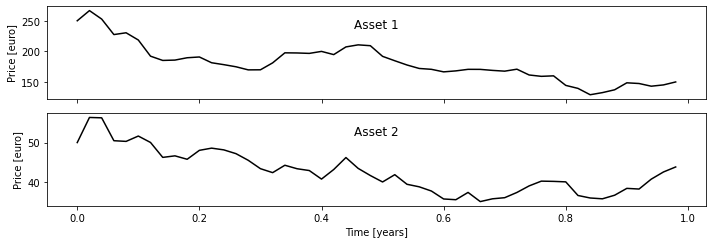

In [5]:
BGMB.plot_one_path()

</h3>Discrepancy BS and MC vs Strike</h3>

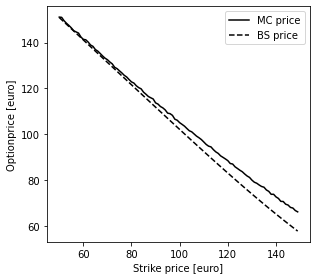

In [131]:
# Assuming Arithmetic Brownian Motion. Calculate MC price and BS price. 

def worker1(rho,K, bachelier=True):
    BGMB_ = multivariate_brownian(Npaths = 100000, Ntimesteps = 50, T = 1,rho=rho, ABM=bachelier)
    return BGMB_.option_price(K)

def worker2(rho,K, bachelier=True):
    BGMB_ = multivariate_brownian(Npaths = 100000, Ntimesteps = 50, T = 1,rho=rho, ABM=bachelier)
    return BGMB_.spread_BS(K)

def BS_MC_strike():
    rho = -1
    strikes = np.arange(50,150,1)
    plt.figure(figsize=(4.5,4))
    optionprices = np.array(Parallel(n_jobs=22)(delayed(worker1)(rho,strike, bachelier=False) for strike in strikes))
    BSprices = np.array(Parallel(n_jobs=22)(delayed(worker2)(rho,strike, bachelier=False) for strike in strikes))
    plt.plot(strikes, optionprices, label='MC price',color='black')
    plt.plot(strikes, BSprices, label='BS price', color='black',ls='--')
    plt.legend()
    plt.xlabel('Strike price [euro]')
    plt.ylabel('Optionprice [euro]')
    plt.tight_layout()
    plt.savefig('MC_vs_BS_ABM.pdf',bbox_inches='tight')
   
 
BS_MC_strike()



<h3>Sensitivity to correlation</h3>

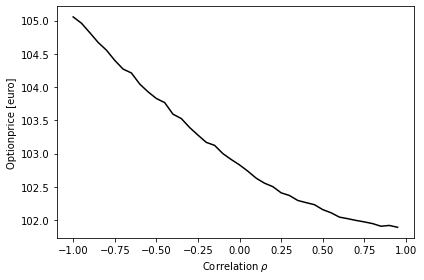

In [33]:

def worker(rho,K):
    BGMB_ = multivariate_brownian(Npaths = 10000000, Ntimesteps = 30, T = 1,rho=rho, ABM=False)
    return BGMB_.option_price(K)

def var_corr():
    K = 100
    rhos = np.arange(-1,1.01,0.05)
    optionprices = np.array(Parallel(n_jobs=11)(delayed(worker)(rho,K) for rho in rhos))
    plt.figure(figsize=(6,4))
    plt.plot(rhos, optionprices,color='black')
    plt.xlabel(r'Correlation $\rho$')
    plt.ylabel('Optionprice [euro]')
    plt.tight_layout()
    plt.savefig('optionprice_vs_corr.pdf')
    
var_corr()

In [6]:
worker(1,100)

101.8759447010336